___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg" width="300px" height="180px" />


# <font color= #bbc28d> **Stock Exchange Forecasting** </font>
#### <font color= #2E9AFE> `Lab 3 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 20/11/2025.

___

<p style="text-align:right;"> Image retrieved from: https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg</p>

# <font color= #bbc28d> **Introduction** </font>

Stock forecasting is one of the most important fields in finance, since **accurate predictions allow for better and more precise decision-making capabilites where investments are involved**. In this sense, data science integration via time series analysis and modeling are essential.

Intending to make use of some popular neural network models and their relevance to finance, this notebook covers the use of **Recurrent Neural Networks (RNN's) for stock exchange forecasting**, focusing on Walmart's stocks over the past 5 years. 

Two baseline models (SMA and ARIMA) will be compared to two RNN's models (RNN and LSTM) to evaluate performance and prediction power. The objective is to identify the best approach and manner to carry out predictions in the field of stock forecasting.

----

In [ ]:
# === IMPORTS ===

# Generales
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Redes Neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import alexnet, AlexNet_Weights, vgg16, VGG16_Weights
from torchvision import transforms
from torch.nn.init import kaiming_uniform_, xavier_uniform_, orthogonal_, zeros_

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Time Series Analysis
import mplfinance as mpf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# <font color= #bbc28d> **Data Loading** </font>

Using the library _yfinance_, the stocks of Walmart in the last five years were downloaded on 14/nov/2025. Open, High, Low, Close and Volume (OHLCV) fields were selected for the download, which will be the features used for model training and evaluation.

In [100]:
# # RUN THIS CODE ONLY ONE TIME
# start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')          # Gets last 5 years of data
# end_date = datetime.now().strftime('%Y-%m-%d')

# # Download Walmart prices
# wmt = yf.download('WMT', start=start_date, end=end_date, progress=True)

# # Flatten columns to get only data
# wmt.columns = wmt.columns.get_level_values(0)

# # Keep OHLCV data
# wmt = wmt[['Open', 'High', 'Low', 'Close', 'Volume']]

# # Save to csv
# wmt.to_csv('data/walmart_stocks.csv', index=True)

In [2]:
# Read data
df = pd.read_csv('data/walmart_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])             # Convert Date column to date type
df = df.set_index('Date')                           # Make the Date column the index
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-16,46.804732,47.697108,46.416065,47.398613,34560300
2020-11-17,46.795404,47.647361,46.384971,46.444050,42711600
2020-11-18,46.596410,47.159198,46.344554,46.356991,24936900
2020-11-19,46.472042,47.401731,46.428512,47.299126,18590700
2020-11-20,47.003731,47.498113,46.580864,46.714565,21937200


# <font color= #bbc28d> **Data Visualization** </font>

For starters, let's take a quick look at the data: 

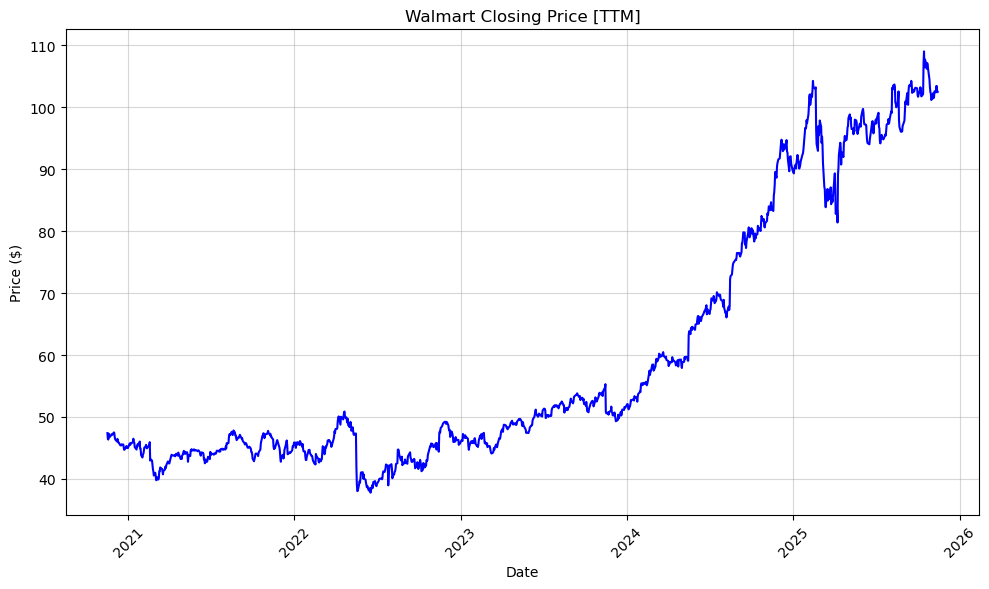

In [11]:
# Initialize an empty figure
plt.figure(figsize=(10, 6))
plt.grid(alpha=0.5)

# Plot the closing prices
plt.plot(
    df.index,
    df["Close"],
    color="blue",
    linewidth=1.5
)

# Set the plot title and axis labels
plt.title(f"Walmart Closing Price [TTM]")
plt.xlabel("Date")
plt.ylabel("Price ($)")

# Finish constructing the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

As observed in the chart, Walmart's stock had been quite stable until around 2023, experiencing a sharp increase the following years.

<br>

Let's take a closer look at Walmart's stock behaviour via OHLCV data analysis with candlesticks charts, which showcase the relationship between OHLCV prices:

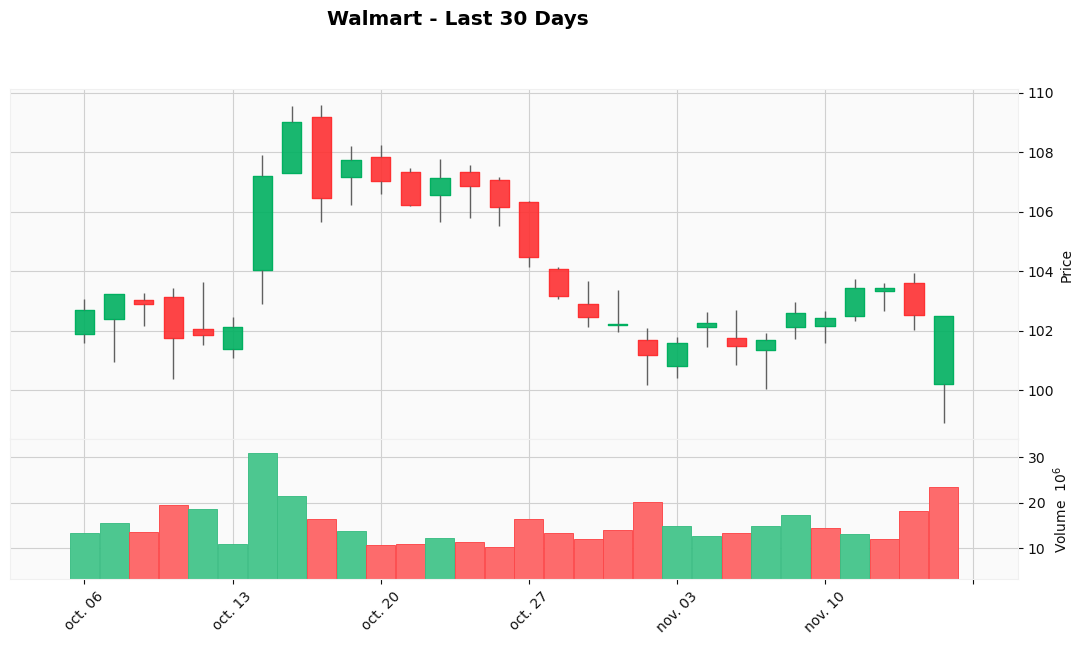

In [12]:
# Select last 30 days of data 
df_latest = df.tail(30)

# plot the latest data, thereby creating a "zoomed in" version of the plot
mpf.plot(
    df_latest,
    type="candle",
    style="yahoo",
    figsize=(14, 7),
    volume=True,
    title=f"Walmart - Last 30 Days"
)

In the last 30 days, Walmart's stock has been experiencing quite a decrease in value, with varying prices. Mostly of which result in worse closing prices at the end of the day.

# <font color= #bbc28d> **Preprocessing** </font>

Although there doesn't seem to be any missing data from the visualizations provided, let's further evaluate if the data contains any NaN values:

In [13]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Since there are no NaN values, the data is good to go through further preprocessing techniques. Firstly, let's apply a train-test-split to avoid data leakage:

In [3]:
# Establish test size
train_size = 0.8
split_index = int(len(df) * train_size)

# Train-Test-Split
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Train Size: {len(train_df)}")
print(f"Train Dates: {train_df.index.min()} to {train_df.index.max()} \n")
print(f"Test Size: {len(test_df)}")
print(f"Test Dates: {test_df.index.min()} to {test_df.index.max()}")

Train Size: 1004
Train Dates: 2020-11-16 00:00:00 to 2024-11-12 00:00:00 

Test Size: 252
Test Dates: 2024-11-13 00:00:00 to 2025-11-14 00:00:00


After applying a train-test-split, scaling the data is recommended, due to the high variance across time. And since data is derived from a time series, the best option is using a MinMaxScaler:

In [192]:
scaler = MinMaxScaler()

# Scale training data
train_df_scaled = scaler.fit_transform(train_df[['Close']])           # Keep only closing values
train_df_scaled = pd.Series(train_df_scaled.flatten(), index=train_df.index)

# Scale testing data
test_df_scaled = scaler.transform(test_df[['Close']])          
test_df_scaled = pd.Series(test_df_scaled.flatten(), index=test_df.index)

- **[PENDIENTE]** Deberíamos tmb checar atípicos pero no entendí series de tiempo alch
- **[PENDIENTE]** También valdría la pena aplicar transformaciones a la serie pero no entendí series de tiempo alch x2

### ehhh,, dunno what about this, it's series decomposing

In [107]:
series_decompose = seasonal_decompose(df['Close'], model='additive', period=7)
# series_decompose.plot()

# <font color= #bbc28d> **Baseline** </font>

The baseline models selected to be compared against RNN architectures are _**Moving Average**_ and _**ARIMA**_. The results of these models will be compared to the RNN architectures proposed later in this notebook.

## <font color= #66b0b0> &ensp; • **Simple Moving Average (SMA)** </font>

Simple Moving Average (SMA) is a model that **calculates the average of a set of data within a specified time frame, shifting with each new data** to provide a clearer view of the overall trend. It helps smooth out data fluctuations and reveals trends over time, however, it does not consider significant fluctuations in data, since all points are weighted equally. 

Due to the simplicity of the SMA model, no further preprocessing of data is needed besides the already applied MinMaxScaler.

In [108]:
# SMA model
def sma_forecast(train_df, test_df, window_size):
    history = list(train_df)                # Start with training values
    preds = []
    
    for i in test_df:
        # Calculate simple moving average
        if len(history) >= window_size:
            pred = np.mean(history[-window_size:])
        else:
            pred = np.mean(history)
        
        preds.append(pred)
        history.append(i)                   # Update with actual test value
    
    return np.array(preds)

Since SMA works with a window size, and as observed in the visualization, stock prices tend to vary quite a lot, a smaller window of 10 days will be used for predictions.

In [109]:
window_size = 10

# Run the model
preds_scaled = sma_forecast(train_df_scaled, test_df_scaled, window_size)

# Re-scale the predictions, since they're in the MinMaxScale scale
preds_original = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()

results = pd.DataFrame({
    'Actual': test_df['Close'].values,
    'SMA_Predicted': preds_original}, 
    index=test_df.index)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(results['Actual'], results['SMA_Predicted']))
mae = mean_absolute_error(results['Actual'], results['SMA_Predicted'])
mape = mean_absolute_percentage_error(results['Actual'], results['SMA_Predicted'])

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape *100:.2f}%')

RMSE: 2.8835
MAE: 2.2514
MAPE: 2.36%


After re-scaling the data for metric evaluation, it's clear that the fitted model performed quite good. It should be noted, however, that the precision of the model is in no short part because of the small window selected.

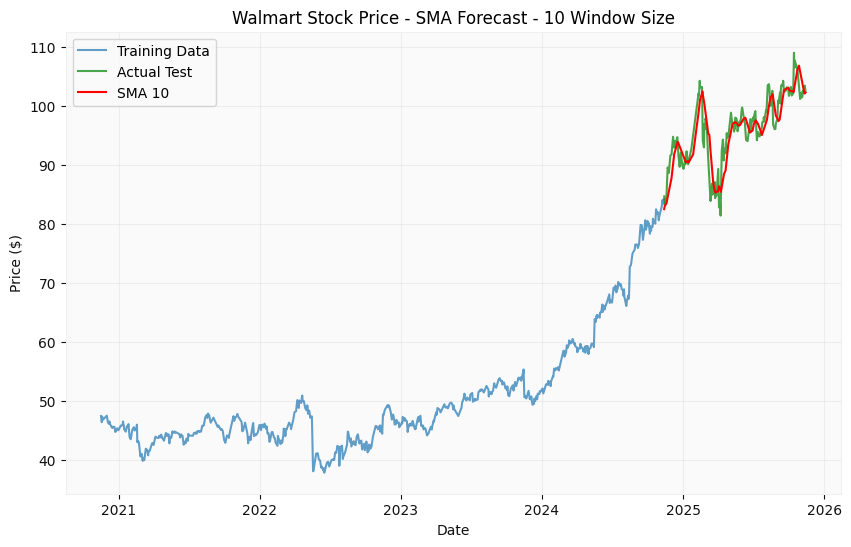

In [110]:
plt.figure(figsize=(10, 6))

plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(results.index, results['SMA_Predicted'], label=f'SMA {window_size}', color='red')

plt.title(f"Walmart Stock Price - SMA Forecast - {window_size} Window Size")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## <font color= #66b0b0> &ensp; • **ARIMA** </font> 

We load the stock data from a CSV file, convert the dates to datetime format, and set them as the index. This prepares the dataset for time series analysis, focusing only on the 'Close' prices.

In [179]:
df = pd.read_csv('data/walmart_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df[['Close']].sort_index()
df.head()

,Close
Date,
2020-11-16,47.398613
2020-11-17,46.444050
2020-11-18,46.356991
2020-11-19,47.299126
2020-11-20,46.714565


We divide the dataset into a train+validation set and a final test set. The train+validation set will be used for model selection via cross-validation, while the test set is reserved for final performance evaluation.

In [180]:
# Tamaño del df
n = len(df)

# Tamaño del test [10 debido a una caída que hay alrededor del 20%]
test_size = int(n * 0.10)

train_val = df['Close'].iloc[:-test_size]  # para cross-validation
test      = df['Close'].iloc[-test_size:]  # predicción final

We define ranges of ARIMA parameters (p, d, q) to try different model configurations. This allows us to systematically explore which combination works best for our data.

In [181]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

results = []

We perform walk-forward cross-validation on the train+validation set:
- Fold division: The train+validation set is split into 5 consecutive folds.

- Expanding window: For each fold, the model is trained on all data up to that fold, simulating real-world forecasting.

- Validation prediction: The model predicts the next fold (the validation window) using only past data.

- RMSE calculation: The error between predictions and actual values is computed for each fold.

- Average RMSE: The mean RMSE across all folds measures how well each ARIMA configuration generalizes over time.

In [182]:
n_folds = 5
fold_size = len(train_val) // n_folds
fold_indices = [fold_size * (i + 1) for i in range(n_folds)]

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            rmse_list = []

            try:
                # Evaluar el modelo en múltiples folds
                for idx in fold_indices:
                    train_fold = train_val.iloc[:idx]
                    val_fold   = train_val.iloc[idx: idx + fold_size]

                    model = ARIMA(train_fold, order=order)
                    model_fit = model.fit()

                    pred = model_fit.forecast(steps=len(val_fold))
                    rmse = np.sqrt(mean_squared_error(val_fold, pred))
                    rmse_list.append(rmse)

                avg_rmse = np.mean(rmse_list)
                results.append((order, avg_rmse))

                print(f"ARIMA{order} -> RMSE PROMEDIO = {avg_rmse:.4f}")

            except:
                print(f"ARIMA{order} falló.")
                continue

ARIMA(0, 0, 0) -> RMSE PROMEDIO = 19.8415
ARIMA(0, 0, 1) -> RMSE PROMEDIO = 14.7712
ARIMA(0, 0, 2) -> RMSE PROMEDIO = 14.4142
ARIMA(0, 0, 3) -> RMSE PROMEDIO = 12.2939
ARIMA(0, 1, 0) -> RMSE PROMEDIO = 6.8257
ARIMA(0, 1, 1) -> RMSE PROMEDIO = 6.8235
ARIMA(0, 1, 2) -> RMSE PROMEDIO = 6.8170
ARIMA(0, 1, 3) -> RMSE PROMEDIO = 6.8232
ARIMA(0, 2, 0) -> RMSE PROMEDIO = 31.4097
ARIMA(0, 2, 1) -> RMSE PROMEDIO = 5.6527
ARIMA(0, 2, 2) -> RMSE PROMEDIO = 5.7294
ARIMA(0, 2, 3) -> RMSE PROMEDIO = 5.6555
ARIMA(1, 0, 0) -> RMSE PROMEDIO = 8.1766
ARIMA(1, 0, 1) -> RMSE PROMEDIO = 8.3136
ARIMA(1, 0, 2) -> RMSE PROMEDIO = 8.2476
ARIMA(1, 0, 3) -> RMSE PROMEDIO = 8.2641
ARIMA(1, 1, 0) -> RMSE PROMEDIO = 6.8220
ARIMA(1, 1, 1) -> RMSE PROMEDIO = 6.8236
ARIMA(1, 1, 2) -> RMSE PROMEDIO = 6.8151
ARIMA(1, 1, 3) -> RMSE PROMEDIO = 6.8202
ARIMA(1, 2, 0) -> RMSE PROMEDIO = 22.3341
ARIMA(1, 2, 1) -> RMSE PROMEDIO = 5.7259
ARIMA(1, 2, 2) -> RMSE PROMEDIO = 5.6830
ARIMA(1, 2, 3) -> RMSE PROMEDIO = 5.6799
ARIMA(2, 0

We select the ARIMA model with the lowest average RMSE from the walk-forward validation. This model is considered the most accurate for forecasting.

In [189]:
results_sorted = sorted(results, key=lambda x: x[1])
best_order, best_rmse = results_sorted[0]

print(f"MEJOR ARIMA{best_order} con RMSE promedio = {best_rmse:.4f}")

MEJOR ARIMA(2, 2, 3) con RMSE promedio = 5.4907


We retrain the selected ARIMA model on the entire train+validation and predict stock prices in the test set:

In [ ]:
# Entrenar Modelo
best_model = ARIMA(train_val, order=best_order).fit()

# Realizar predicciones
pred_test = best_model.forecast(steps=len(test))

# Valores reales del Test
y_true = test.values

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_true, pred_test))

# MAE
mae_test = mean_absolute_error(y_true, pred_test)

print(f"Test RMSE = {rmse_test:.4f}")
print(f"Test MAE  = {mae_test:.4f}")

Test RMSE = 4.3104
Test MAE  = 3.7266


We plot the train+validation series, the actual test data, and the ARIMA predictions to visually assess how well the model captures trends and changes in the stock prices.

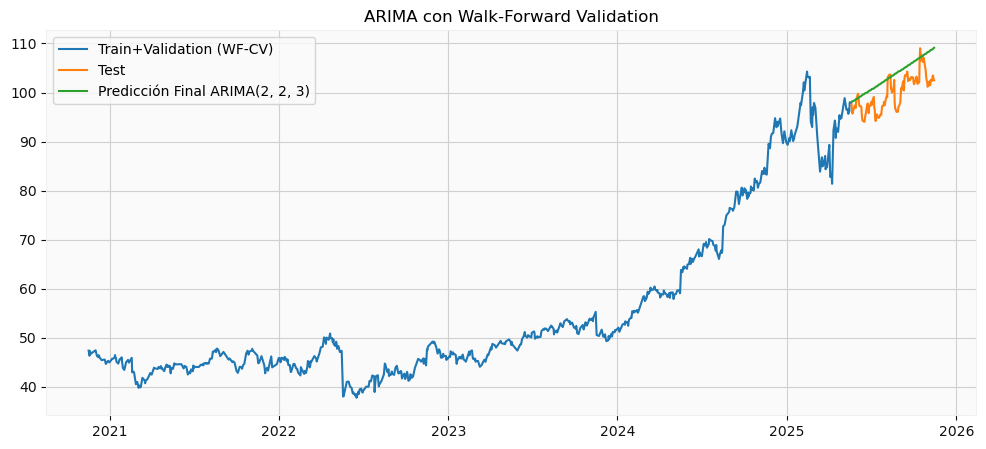

In [185]:
plt.figure(figsize=(12,5))
plt.plot(train_val.index, train_val, label="Train+Validation (WF-CV)")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred_test, label=f"Predicción Final ARIMA{best_order}")
plt.legend()
plt.title("ARIMA con Walk-Forward Validation")
plt.show()

# <font color= #bbc28d> **Modeling** </font>

## <font color= #66b0b0> &ensp; • **Vanilla RNN** </font>
A **vanilla RNN** is the **simplest** form of a recurrent neural network, designed to process sequential data by using feedback loops to maintain an internal memory called a `"hidden state"`. It applies the same weights at each step of the sequence to update the hidden state based on the current input and the previous state, allowing it to capture short-term dependencies.

In [4]:
# Scale the whole dataframe features
scaler = MinMaxScaler()

# Scale training data
X_train_scaled = scaler.fit_transform(train_df)           
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=train_df.columns)

# Scale testing data
X_test_scaled = scaler.transform(test_df)          
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=test_df.columns)

This code transforms the time series into sequences for an RNN. For each point, it takes the previous lookback steps as input X and the next horizon step(s) of the first column (e.g., 'Close') as target y. The window slides across the dataset to generate many input-output pairs:

In [5]:
def create_sequences(df, lookback=30, horizon=1):
    X, y = [], []
    data = df.values
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])  # predecimos la primera columna, por ejemplo 'Close'
    return np.array(X), np.array(y)

lookback = 60
horizon = 1

X_train, y_train = create_sequences(X_train_scaled, lookback, horizon)
X_test, y_test   = create_sequences(X_test_scaled, lookback, horizon)

To be able to use them with torch, we have to convert them to tensors:

In [6]:
# Convertirlos a tensores
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

The RNN reads a sequence of past values, like the last 30 days of stock prices, and remembers patterns in the data. After processing the entire sequence, it uses only the last memory (hidden state) to predict the next value. The prediction is compared to the actual value using MSE loss, and the model updates itself with the Adam optimizer to improve future predictions.

In [7]:
# Definir el vanilla RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # tomar la última salida
        return out

input_size = X_train.shape[2]  # número de features
model = RNNModel(input_size=input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train our RNN model over a number of epochs, in this cae 50, and for each epoch the model processes the training sequences to generate predictions and calculate its MSE updating its weights using Adam to get better results.

After it finishes iterating, we save the final weights of the model to just load them to make predictions:.

Epoch 1, Train Loss: 0.000174, RMSE: 0.013205
Epoch 2, Train Loss: 0.000174, RMSE: 0.013199
Epoch 3, Train Loss: 0.000174, RMSE: 0.013192
Epoch 4, Train Loss: 0.000174, RMSE: 0.013186
Epoch 5, Train Loss: 0.000174, RMSE: 0.013179
Epoch 6, Train Loss: 0.000174, RMSE: 0.013173
Epoch 7, Train Loss: 0.000173, RMSE: 0.013166
Epoch 8, Train Loss: 0.000173, RMSE: 0.013160
Epoch 9, Train Loss: 0.000173, RMSE: 0.013154
Epoch 10, Train Loss: 0.000173, RMSE: 0.013147
Epoch 11, Train Loss: 0.000173, RMSE: 0.013141
Epoch 12, Train Loss: 0.000173, RMSE: 0.013135
Epoch 13, Train Loss: 0.000172, RMSE: 0.013128
Epoch 14, Train Loss: 0.000172, RMSE: 0.013122
Epoch 15, Train Loss: 0.000172, RMSE: 0.013116
Epoch 16, Train Loss: 0.000172, RMSE: 0.013110
Epoch 17, Train Loss: 0.000172, RMSE: 0.013104
Epoch 18, Train Loss: 0.000172, RMSE: 0.013097
Epoch 19, Train Loss: 0.000171, RMSE: 0.013091
Epoch 20, Train Loss: 0.000171, RMSE: 0.013085
Epoch 21, Train Loss: 0.000171, RMSE: 0.013079
Epoch 22, Train Loss: 

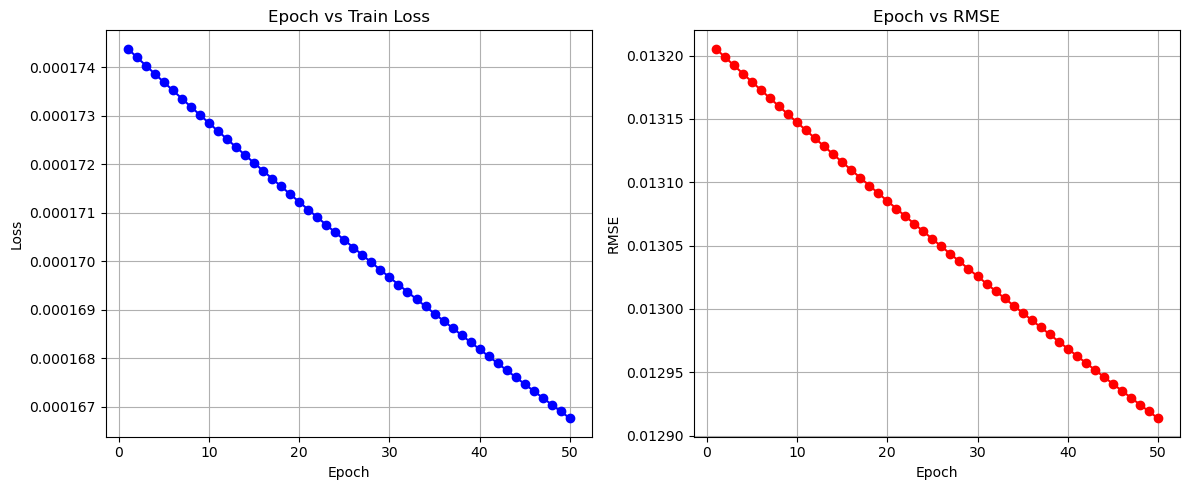

In [17]:
# Definir los parámetros
epochs = 50
train_losses = []
train_rmses = []

# Iterar por cada época y calcular su loss
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Guardar loss
    train_losses.append(loss.item())
    
    # Calcular RMSE
    rmse = torch.sqrt(loss).item()
    train_rmses.append(rmse)
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.6f}, RMSE: {rmse:.6f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), "rnn_model_scaled.pth")

# Graficar Epoch vs Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o', color='blue')
plt.title("Epoch vs Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Graficar Epoch vs RMSE
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_rmses, marker='o', color='red')
plt.title("Epoch vs RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()

Now that we vae trained our RNN we evaluate theRNN on the test set, generate predictions without gradients, and convert both predictions and true values back to the original scale for the 'Close' price while also calcutaing its performance metrics:

In [18]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test).numpy()

# Inverse scaling para la primera columna [Close]
y_test_df = pd.DataFrame(y_test.numpy(), columns=[X_train_scaled.columns[0]])
test_pred_df = pd.DataFrame(test_pred, columns=[X_train_scaled.columns[0]])

y_test_inv = scaler.inverse_transform(pd.concat([y_test_df, pd.DataFrame(np.zeros((y_test_df.shape[0], X_train_scaled.shape[1]-1)))], axis=1))[:,0]
test_pred_inv = scaler.inverse_transform(pd.concat([test_pred_df, pd.DataFrame(np.zeros((test_pred_df.shape[0], X_train_scaled.shape[1]-1)))], axis=1))[:,0]

# Calcular las métricas
rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
mae = mean_absolute_error(y_test_inv, test_pred_inv)
mape = np.mean(np.abs((y_test_inv - test_pred_inv) / y_test_inv)) * 100
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

Test RMSE: 3.5412, MAE: 3.1843, MAPE: 3.2121


We can plot the predicted vs the real values just to have a visualization on how the look compared to the real data, for that we will have to re.convert the data that the RNN gives back to a df compatible with our original data:

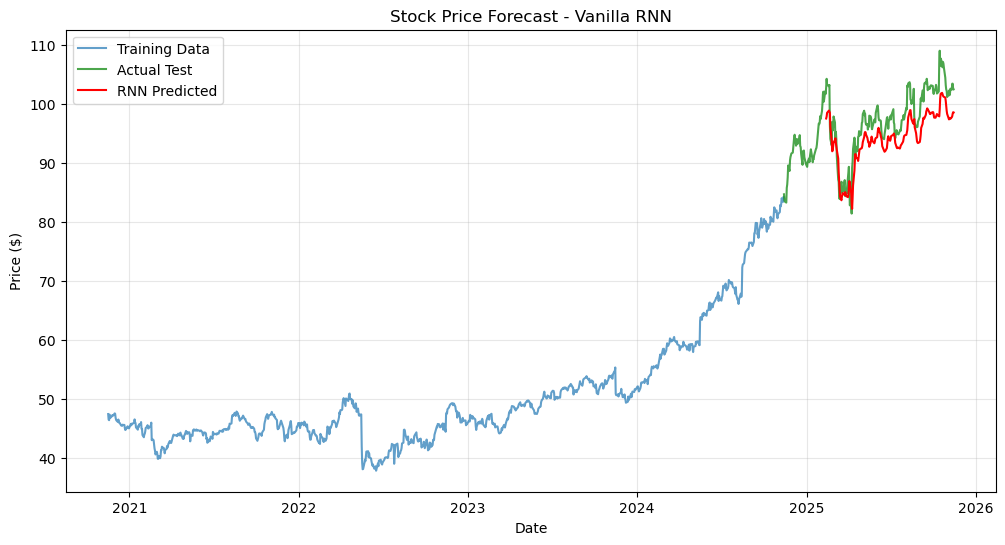

In [19]:
# Definir variables 
sequence_length = lookback          # Número de pasos anteriores que usamos como entrada
prediction_horizon = horizon       # Número de pasos hacia adelante que queremos predecir

# Crear un dataframe para almacenar los resultados
# No hay datos para sequence_length + prediction_horizon - 1
results = test_df.iloc[sequence_length + prediction_horizon - 1:].copy()

# Agregar las predicciones de la RNN como una nueva columna
results['RNN_Predicted'] = test_pred_inv.flatten()

# Plotear verdaderos vs predichos
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(results.index, results['RNN_Predicted'], label='RNN Predicted', color='red')
plt.title("Stock Price Forecast - Vanilla RNN")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

We can see that the RNN does a pretty good job at predicting values, and if we increased the number of epochs we could raise it's value even more, however, vanilla RNNs **struggle with long-term dependencies** due to the vanishing gradient problem, which causes them to "forget" information from earlier in the sequence. 

LSTM and GRU are able to address the vanishing gradient problem more effectively than vanilla RNNs, making them a better choice for processing long sequences. So let´s try a LSTM model to compare them.

## <font color= #66b0b0> &ensp; • **LSTM** </font>

Long Short-Term Memory models are a type of neural network that excels in time series forecasting. LSTMs are known for remembering information for long periods, **[más explicación]**

Since LSTM is a different kind of model, that accepts multiple features, we're going to run back the preprocessing, now taking into account all of the OHLCV features.

In [111]:
# Scale the whole dataframe features
scaler = MinMaxScaler()

# Scale training data
X_train_scaled = scaler.fit_transform(train_df)           
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=train_df.columns)

# Scale testing data
X_test_scaled = scaler.transform(test_df)          
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=test_df.columns)

Firstly, data has to be correctly loaded into PyTorch. This includes building sequences and converting the sequences to tensors.

In [112]:
# Constants
sequence_length = 60  # sliding window
prediction_horizon = 1  # predicting next day

# Convert to sequences
def create_sequences(data, seq_length, pred_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        X.append(data.iloc[i:i+seq_length])
        y.append(data.iloc[i+seq_length+pred_horizon-1]['Close'])  # Output is only the Closing price
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, sequence_length, prediction_horizon)
X_test, y_test = create_sequences(X_test_scaled, sequence_length, prediction_horizon)

In [113]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

Define LSTM:

In [114]:
# Hyperparameters
hidden_size = 50
num_layers = 2
batch_size = 64
num_epochs = 50
learning_rate = 0.001

# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last time step
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
model = LSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [115]:
# Training
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Prediction
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

Epoch [10/50], Loss: 0.091690
Epoch [20/50], Loss: 0.040555
Epoch [30/50], Loss: 0.017961
Epoch [40/50], Loss: 0.005391
Epoch [50/50], Loss: 0.002832


In [116]:
# Get min and max of Close from training data (used in MinMax scaling)
close_min = train_df['Close'].min()
close_max = train_df['Close'].max()

# Inverse transform predictions
y_pred_train_inv = y_pred_train * (close_max - close_min) + close_min
y_pred_test_inv  = y_pred_test  * (close_max - close_min) + close_min

# Also inverse-transform true y_test for plotting
y_test_inv = y_test.numpy() * (close_max - close_min) + close_min

In [117]:
# Metrics
rmse = np.sqrt(mean_squared_error(y_test.numpy(), y_pred_test))
mae = mean_absolute_error(y_test.numpy(), y_pred_test)
mape = np.mean(np.abs((y_test.numpy() - y_pred_test) / y_test.numpy())) * 100

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 0.0985
MAE: 0.0847
MAPE: 6.50%


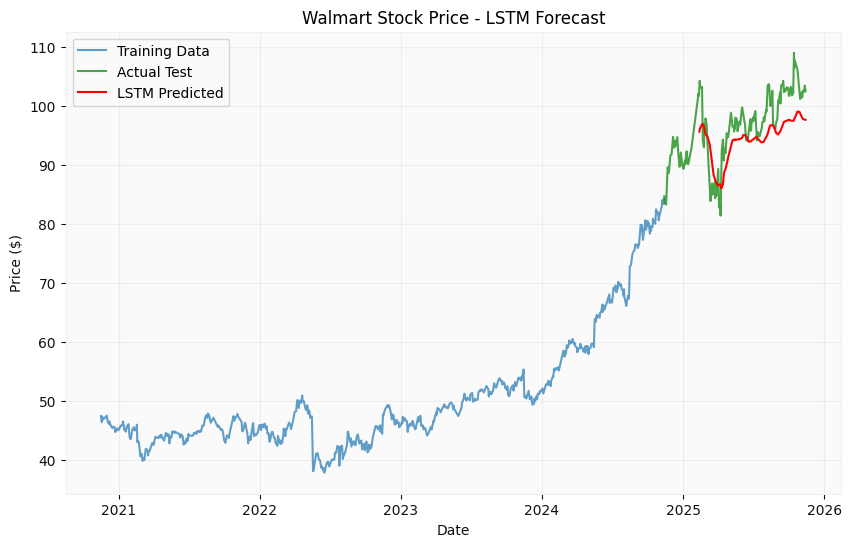

In [118]:
# Results dataframe
results = test_df.iloc[sequence_length+prediction_horizon-1:].copy()
results['LSTM_Predicted'] = y_pred_test_inv.flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(results.index, results['LSTM_Predicted'], label='LSTM Predicted', color='red')
plt.title("Walmart Stock Price - LSTM Forecast")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## more preprocessing

Additional preprocessing for LSTM

In [129]:
# Hyperparameters
sequence_length = 60
prediction_horizon = 1
hidden_size = 100  # increased
num_layers = 3     # increased
dropout_prob = 0.3 # added dropout
batch_size = 64
num_epochs = 70    # increased
learning_rate = 0.001

In [130]:
# Apply log transformation on OHLC prices to stabilize variance
for col in ['Open', 'High', 'Low', 'Close']:
    train_df.loc[:, col] = np.log1p(train_df[col])
    test_df.loc[:, col] = np.log1p(test_df[col])

# Volume normalization: StandardScaler for volume only
volume_scaler = StandardScaler()
train_df.loc[:, 'Volume'] = volume_scaler.fit_transform(train_df[['Volume']])
test_df.loc[:, 'Volume'] = volume_scaler.transform(test_df[['Volume']])

# MinMax scaling on all features after log and volume scaling
feature_scaler = MinMaxScaler()
train_scaled = feature_scaler.fit_transform(train_df)
test_scaled = feature_scaler.transform(test_df)

In [131]:
def create_sequences(data, seq_length, pred_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+pred_horizon-1, 3])  # Close column index
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, sequence_length, prediction_horizon)
X_test, y_test = create_sequences(test_scaled, sequence_length, prediction_horizon)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

In [132]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
model = LSTM(input_size, hidden_size, num_layers, dropout_prob)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/70], Loss: 0.054361
Epoch [20/70], Loss: 0.027497
Epoch [30/70], Loss: 0.008199
Epoch [40/70], Loss: 0.003993
Epoch [50/70], Loss: 0.003784
Epoch [60/70], Loss: 0.003178
Epoch [70/70], Loss: 0.003027


In [133]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).numpy()

# Inverse scaling of target variable (Close)
# Close was log1p transformed and scaled
close_index = train_df.columns.get_loc('Close')

# Inverse MinMax scaling of Close (on scaled data)
close_min = feature_scaler.data_min_[close_index]
close_max = feature_scaler.data_max_[close_index]

y_pred_test_rescaled = y_pred_test * (close_max - close_min) + close_min
y_test_rescaled = y_test.numpy() * (close_max - close_min) + close_min

# Inverse log1p transform
y_pred_test_final = np.expm1(y_pred_test_rescaled)
y_test_final = np.expm1(y_test_rescaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_test_final))
mae = mean_absolute_error(y_test_final, y_pred_test_final)
mape = np.mean(np.abs((y_test_final - y_pred_test_final) / y_test_final)) * 100

print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%')

RMSE: 0.0093, MAE: 0.0088, MAPE: 0.88%


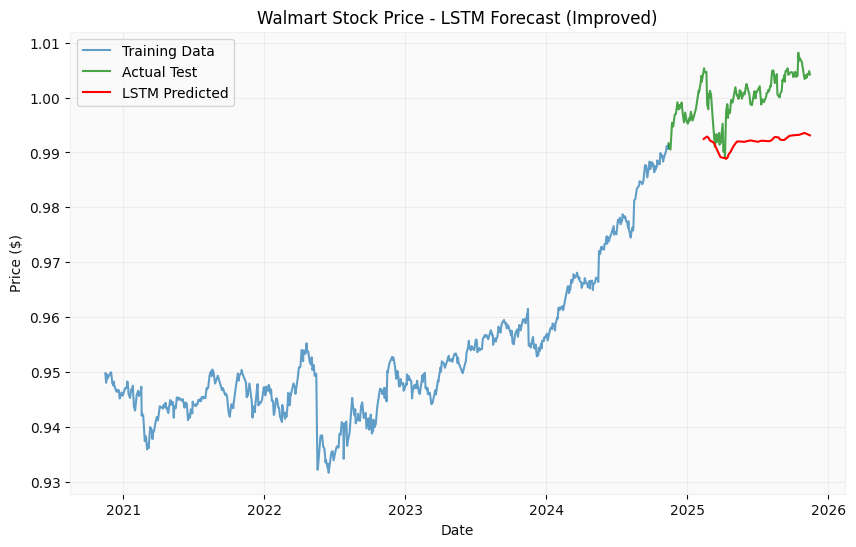

In [134]:
# Plot results
results = test_df.iloc[sequence_length + prediction_horizon - 1:].copy()
results = results.iloc[:len(y_pred_test_final)]
results['LSTM_Predicted'] = y_pred_test_final.flatten()

plt.figure(figsize=(10, 6))
plt.plot(train_df.index, np.expm1(train_df['Close']), label='Training Data', alpha=0.7)
plt.plot(test_df.index, np.expm1(test_df['Close']), label='Actual Test', alpha=0.7, color='green')
plt.plot(results.index, results['LSTM_Predicted'], label='LSTM Predicted', color='red')
plt.title("Walmart Stock Price - LSTM Forecast (Improved)")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# <font color= #bbc28d> **Validation** </font>

# <font color= #bbc28d> **Bibliography** </font>

- https://pythonfintech.com/articles/plotting-stock-charts-ohlc-matplotlib-mplfinance

- https://www.geeksforgeeks.org/data-analysis/time-series-forecasting-using-pytorch